In [20]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt
import pickle

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'lifecycle_mapping', 'plot1D', 'plot2D', 'plotCondPDFs']
Own modules available: ['PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_load_RCEMIP_SAM', 'fcns_movie', 'fcns_multiscale_extremes', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_DYAMOND_SAM_Tb_Feng']


In [3]:
%autoreload 2

# to access segmentation files and simulation outputs
from fcns_load_DYAMOND_SAM import *
# to access TOOCAN objects
from load_TOOCAN_DYAMOND_modif_BF import *
# display functions
from fcns_movie import *
# plotting
from plot1D import *

In [49]:
figdir = os.path.join(os.path.dirname(workdir),'figures/snapshots')
os.makedirs(figdir,exist_ok=True)

In [4]:
# load relation table
relation_table = loadRelTable('DYAMOND_SEG')

In [5]:
def loadCaseStudy(varid,region,mask):
    
    varid_str = varid
    if varid == 'Prec':
        varid_str = 'pr'
    # output dir
    dir_in = os.path.join(DIR_OUT,region,varid,mask)
    # save
    cs = pickle.load(open(os.path.join(dir_in,'case_study.pickle'),'rb'))
    # output
    return cs

In [6]:
# Try copying data in xarray dataArray to plot with existing function

def npArray2XrDataArray(np_array):
    
    da_to_show = xr.DataArray(
        data=np_array[np.newaxis,...],
        dims=["time","latitude", "longitude"],
        coords=dict(
            longitude=(segmask.longitude),
            latitude=(segmask.latitude),
            time=(segmask.time),
        ),
        attrs=dict(
            description="TOOCAN segmentation mask.",
            units="",
        ),
    )
    
    return da_to_show

In [40]:
def showSnapshotAndMcs(ax,slice_lon,slice_lat,data=None,segmask=None,title='',data_color_mode='linear',MCS_color_mode='cyclic'):
    """If MCS_color_mode == 'cyclic', all colors are cyclic with period 10.
    """
    
    ims = []

    # test if longitude range spans longitude 0º
    if (slice_lon.start - 180)*(slice_lon.stop - 180) < 0:
        print('show each side of longitude 0º')
        s_lon_all = slice(slice_lon.start,360),slice(0,slice_lon.stop)
        lon_lim = slice_lon.start-360,slice_lon.stop
    else:
        print('only one side of longitude 0º')
        s_lon_all = [slice_lon]
        lon_lim = slice_lon.start,slice_lon.stop
    
    print(s_lon_all)
    
    # lat
    lat_lim = slice_lat.start,slice_lat.stop
    
    for s_lon in s_lon_all:
        
        im_slice = []

        #- background

        if data is not None:

            # coords
            lonarray_dyamond,latarray_dyamond = getCoords2D(data,s_lon,slice_lat)            
            # data
            Z = data.sel(lon=s_lon,lat=slice_lat)
            # show
            # im = ax.pcolormesh(np.ravel(lonarray_dyamond),np.ravel(latarray_dyamond),np.ravel(Z),transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
            im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
            im.set_clim(*clim)
            
            im_slice.append(im)

        #- MCSs
        
        if segmask is not None:

            # coords
            lonarray_toocan,latarray_toocan = getCoords2D(segmask,s_lon,slice_lat) 
            # print(lonarray_toocan.shape,latarray_toocan.shape)
            # data
            IMG_SEG = segmask.sel(longitude=s_lon,latitude=slice_lat)[0]
            print(IMG_SEG.shape)
            if MCS_color_mode == 'cyclic':
                IMG_SEG = IMG_SEG%10
            # print(IMG_SEG.shape)
            # show
            im_MCS = ax.pcolormesh(lonarray_toocan,latarray_toocan,IMG_SEG,transform=ccrs.PlateCarree(),cmap=cmap_mcs,alpha=0.1,edgecolor='none')

            # store image placeholders for later updating
            im_slice.append(im_MCS)
            
        # print('add',im_slice)
        ims.append(im_slice)

    # delete data and remove from memory
    if data is not None:
        del Z
    if segmask is not None:
        del IMG_SEG
    gc.collect()
    
    # cosmetics
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    # showColorBar(fig,ax,im)
        
    ax.set_extent([*lon_lim, *lat_lim],crs=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines('110m')
    ax.gridlines()
    
    return ims

In [7]:
varid = 'Prec'
region = 'tropics'
mask = 'all'

cs = loadCaseStudy(varid,region,mask)

In [8]:
cs.dist_pr_all

< DistributionChunked object:
 . bintype: invlogQ
 . nbins: 81
 . nbpd: 10
 . nppb: 4
 . nd: 8
 . fill_last_decade: False
 . name: pr, all, DYAMOND-SAM tropics, all times
 . size: 15238250496
 . vmin: -0.075976014
 . vmax: 125.83331
 . rank_edges: <class 'numpy.ndarray'>
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: None
 . bin_locations_stored: [False False False ... False False False]
 . overwrite: False
 . dist_chunks: <class 'list'>
 . chunks_to_ignore: <class 'list'>
 . nchunks: 1086
 . size_chunks: <class 'list'>
 . vmin_chunks: <class 'list'>
 . vmax_chunks: <class 'list'>
 . bin_locations: {}
 >

In [27]:
# at specific i_t
i_t = i_t_test = 600

# 1. get array of varid (precipitation) and TOOCAN segmentation mask

# load prec for that date
pr = loadPrec(i_t,relation_table)
# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t_test,relation_table)

In [48]:
def getSubplotRange(lon_lim,lat_lim):

    ## image
    # cmap = plt.cm.RdBu
    # cmap = plt.cm.BuPu
    cmap = plt.cm.GnBu
    # cmap_mcs = plt.cm.get_cmap('rainbow', 10)
    cmap_mcs = plt.cm.get_cmap('Accent', 10)
    slice_lat = slice(*lat_lim)
    slice_lon = slice(*lon_lim)

    # compute figure size
    dlon = np.diff(lon_lim)[0] % 360
    dlat = np.diff(lat_lim)[0]
    Lx_fig = 15
    Lx_cbar = 1.5
    Ly_title = 1
    Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title

    return slice_lon,slice_lat,Lx_fig,Ly_fig

only one side of longitude 0º
[slice(300, 350, None)]
(518, 1280)


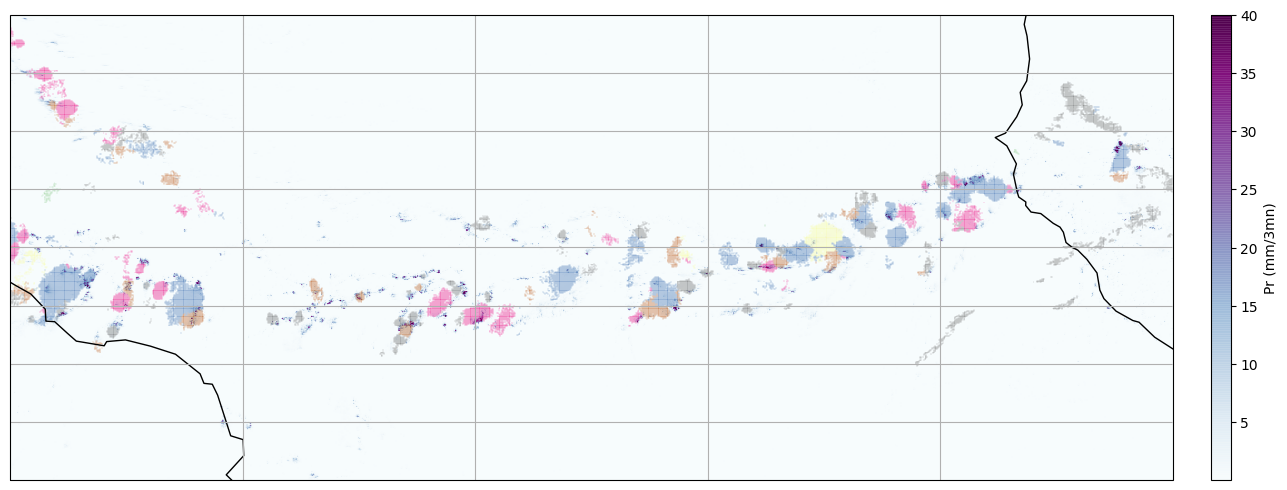

In [51]:
## GRAPHICAL PARAMETERS
clim = (1e-3,40)
lon_lim = (300,350)
lat_lim = (0,20)

slice_lon,slice_lat,Lx_fig,Ly_fig = getSubplotRange(lon_lim,lat_lim)


# SHOW IMAGE

# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims = showSnapshotAndMcs(ax,slice_lon,slice_lat,data=pr,segmask=segmask,MCS_color_mode='linear')
    
    # showColorBar(fig,ax,ims[0][0],label='Pr (mm/3mn)')
    showColorBar(fig,ax,ims[0][0],label='Pr (mm/3mn)')
    
plt.savefig(os.path.join(figdir,'snapshot_rain_MCS_index_%d_lon_%s_%s_lat_%s_%s.png'%(i_t,*lon_lim,*lat_lim)),dpi=400,bbox_inches='tight')

In [11]:
# 2. digitize sample values in distribution bins
digits = dist_var.getBinIndices(sample) # (flattened)
N_dig = dist_var.ranks.size

# 3. for each bin i, apply diagnostic to the metric and save sample size
# init
diag_all_bins = np.full(N_dig,np.nan)
N_all_bins = np.full(N_dig,np.nan)
N_valid_all_bins = np.full(N_dig,np.nan)
# loop
for i_bin in range(0,N_dig):

    # x-y mask in bin i
    mask_bin = (digits == i_bin)
    # take intersection with spatial mask
    mask_bin = np.logical_and(mask_bin,xymask)
    # take intersection with MCS duration mask
    mask_bin = np.logical_and(mask_bin,Tmask)

    # extract age in bin
    age_in_bin = metric[mask_bin]

    # get bin sample size
    N_all_bins[i_bin] = age_in_bin.size
    N_valid_all_bins[i_bin] = np.sum(~np.isnan(age_in_bin))
    # if N_valid_all_bins[i_bin] == 0:
    #     print('bin #%d = all nans'%i_bin)

    # apply diagnostic
    if diag in ['mean','max','var','min']:

        if N_valid_all_bins[i_bin] > 0:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                diag_all_bins[i_bin] = getattr(np,'nan%s'%diag)(age_in_bin)
        else:
            diag_all_bins[i_bin] = 0

NameError: name 'dist_var' is not defined